### Lensing Visualizer


##### Objective: The code helps us to visualize the lensing effects by an astronomical object (in the geometric optics approximation)


With the recent studies on five different lens structures, namely point mass object, double point mass, singular isothermal sphere, singular ellipsoidal sphere and Navarro-Frenk-White lensing objects. An interactive tool can be used to visualize dependency of the extrinsic source properties (position and spread) as well as the instrinsic lens properties (orientation and matter distribution). The resolution of the observing object is set at around that of Hubble Space Telescope at an estimated resolution of 2.5e-7 radians. 

Please note, for the sake of the smoothness of the simulation, we recommend lowering the resolution by a factor of 10. Thanks!

The theory of gravitational lensing can be studied (for all these lenses and many others) from: Thesis work of Takahashi http://cosmo.phys.hirosaki-u.ac.jp/takahasi/dt.pdf

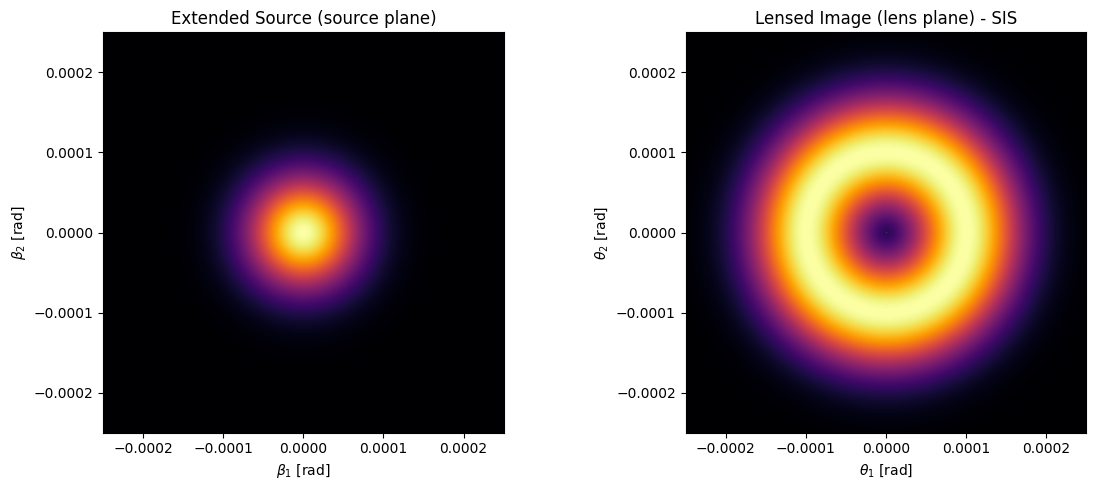

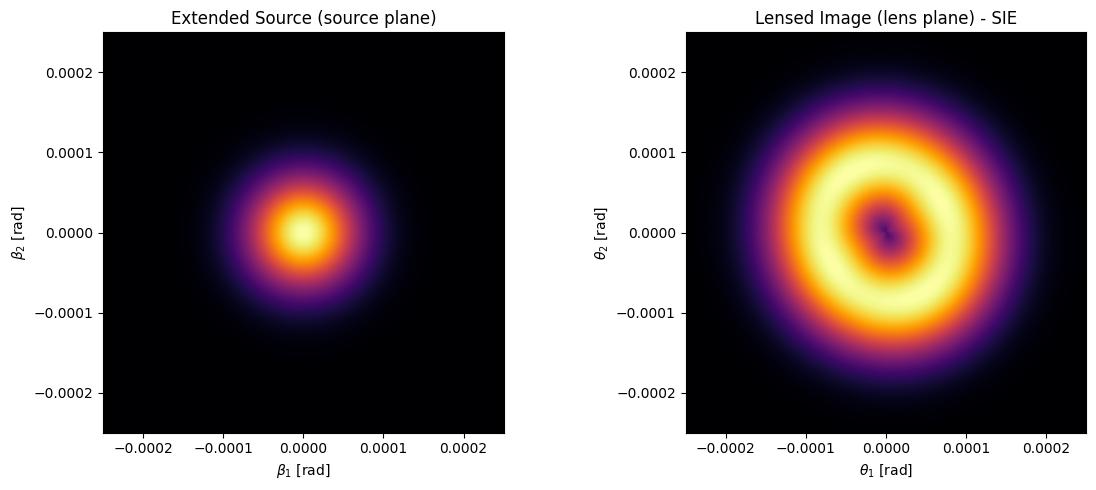

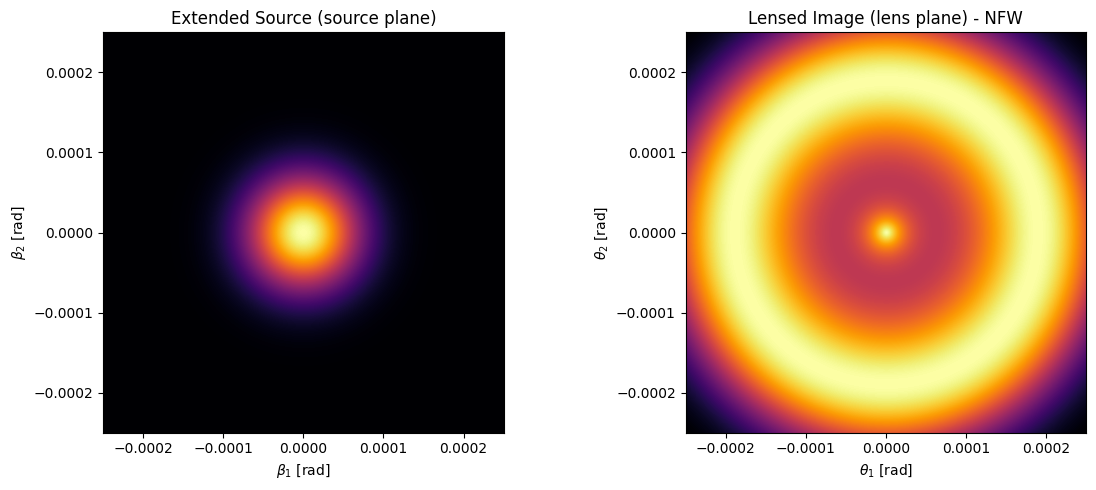

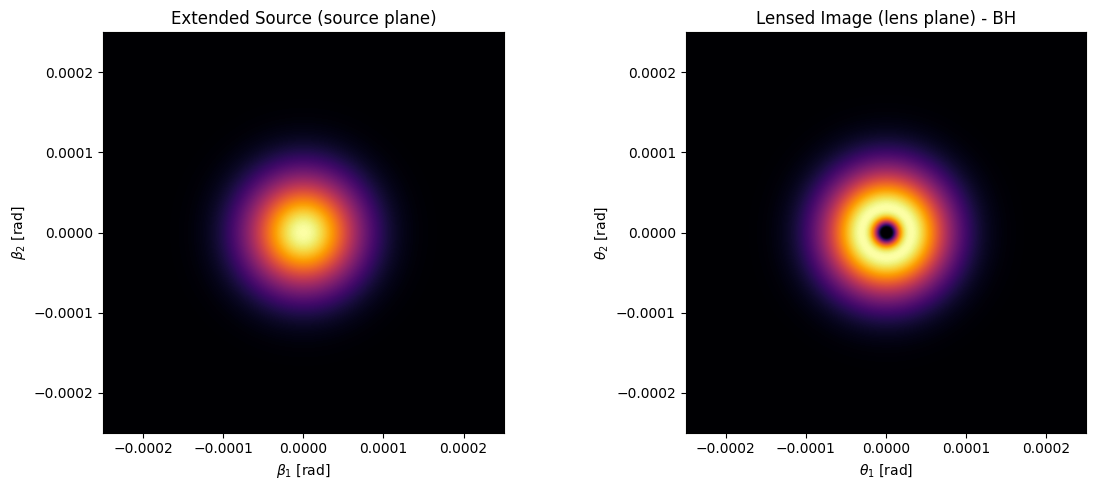

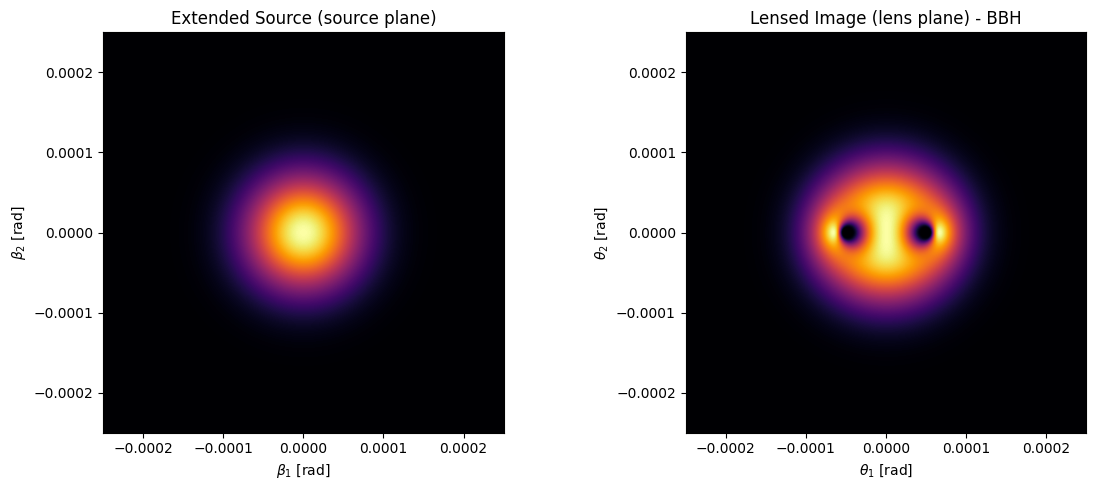

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

# Constants
G = 6.67430e-11  # m^3 kg^-1 s^-2
c = 299792458    # m/s
pc = 3.0857e16   # m
M_sun = 1.98847e30  # kg

def create_angular_grid(n, theta_max):
    theta1 = np.linspace(-theta_max, theta_max, n)
    theta2 = np.linspace(-theta_max, theta_max, n)
    theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)
    return theta1, theta2, theta1_grid, theta2_grid

# --- Lens models ---

def sis_potential(theta1, theta2, theta_E=1e-4):
    """
    Compute SIS lensing potential ψ(θ) = θ_E * |θ|.
    theta1, theta2: 2D arrays of angular coordinates (radians)
    theta_E: Einstein radius (radians)
    Returns: 2D array psi
    """
    theta = np.sqrt(theta1**2 + theta2**2)
    psi = theta_E * theta
    psi[theta == 0] = 0  # avoid singularity at center
    return psi

def sis_deflection(theta1, theta2, theta_E=1e-4):
    """
    Compute SIS deflection angles α = ∇ψ from potential.
    Returns: alpha1, alpha2 arrays (same shape as theta1, theta2)
    """
    psi = sis_potential(theta1, theta2, theta_E)
    dtheta = theta1[0,1] - theta1[0,0]  # grid spacing in radians (assumes uniform grid)
    alpha1 = np.gradient(psi, dtheta, axis=1)
    alpha2 = np.gradient(psi, dtheta, axis=0)
    return alpha1, alpha2

def sie_deflection(theta1_grid, theta2_grid, theta_E=1e-4, q=0.7, phi_deg=30):
    """
    Singular Isothermal Ellipsoid deflection.
    Returns deflection angles alpha1, alpha2.
    Reference: Kormann+1994.
    """
    phi = np.radians(phi_deg)
    # Rotate coordinates by -phi
    x = theta1_grid * np.cos(phi) + theta2_grid * np.sin(phi)
    y = -theta1_grid * np.sin(phi) + theta2_grid * np.cos(phi)
    eps = np.sqrt(1 - q**2)
    psi_ellip = np.sqrt(q**2 * x**2 + y**2)

    # Avoid divide by zero
    psi_ellip[psi_ellip == 0] = 1e-10

    # Deflections in rotated frame
    alpha_x = theta_E * q / eps * np.arctan(eps * x / psi_ellip)
    alpha_y = theta_E * q / eps * np.arctanh(eps * y / psi_ellip)

    # Rotate deflections back to original frame
    alpha1 = alpha_x * np.cos(phi) - alpha_y * np.sin(phi)
    alpha2 = alpha_x * np.sin(phi) + alpha_y * np.cos(phi)

    return alpha1, alpha2

def nfw_deflection(theta1_grid, theta2_grid, r_s=2e-4, kappa_s=0.5):
    """
    NFW profile deflection.
    Adapted from Bartelmann (1996).
    """
    theta = np.sqrt(theta1_grid**2 + theta2_grid**2)
    x = theta / r_s
    alpha = np.zeros_like(theta)

    def f(x):
        # Piecewise function for NFW deflection profile
        if x < 1:
            return np.log(x/2)**2 - np.arccosh(1/x)**2
        elif x == 1:
            return 1 - np.log(2)
        else:
            return np.log(x/2)**2 + np.arccos(1/x)**2

    # Vectorized implementation of f(x)
    f_vec = np.zeros_like(x)
    mask1 = x < 1
    mask2 = x == 1
    mask3 = x > 1

    f_vec[mask1] = np.log(x[mask1]/2)**2 - np.arccosh(1/x[mask1])**2
    f_vec[mask2] = 1 - np.log(2)
    f_vec[mask3] = np.log(x[mask3]/2)**2 + np.arccos(1/x[mask3])**2

    # Avoid division by zero at center
    alpha[x == 0] = 0
    alpha[x != 0] = 4 * kappa_s * r_s / x[x != 0] * f_vec[x != 0]

    # Components of deflection vector
    alpha1 = alpha * (theta1_grid / (theta + 1e-20))
    alpha2 = alpha * (theta2_grid / (theta + 1e-20))

    return alpha1, alpha2

def bbh_deflection(theta1_grid, theta2_grid,
                   M1=1e15*M_sun, M2=1e15*M_sun,
                   D_l=1e9*pc, D_s=2e9*pc,
                   separation=1e-4):
    # BH1 at (-sep/2, 0), BH2 at (+sep/2,0)
    t1_1 = -separation/2
    t2_1 = 0
    t1_2 = +separation/2
    t2_2 = 0
    # Deflection from BH1
    dx1 = theta1_grid - t1_1
    dy1 = theta2_grid - t2_1
    r2_1 = dx1**2 + dy1**2
    r2_1[r2_1 == 0] = 1e-12
    p1 = 4 * G * M1 / c**2 * ((D_s - D_l) / (D_l * D_s))
    a1_1 = p1 * dx1 / r2_1
    a2_1 = p1 * dy1 / r2_1
    # Deflection from BH2
    dx2 = theta1_grid - t1_2
    dy2 = theta2_grid - t2_2
    r2_2 = dx2**2 + dy2**2
    r2_2[r2_2 == 0] = 1e-12
    p2 = 4 * G * M2 / c**2 * ((D_s - D_l) / (D_l * D_s))
    a1_2 = p2 * dx2 / r2_2
    a2_2 = p2 * dy2 / r2_2
    # Total
    return a1_1 + a1_2, a2_1 + a2_2


def bh_einstein_radius(M=1e11*M_sun, D_l=1e9*pc, D_s=2e9*pc):
    """
    Calculate Einstein radius in radians for point mass lens.
    """
    D_ls = D_s - D_l
    theta_E = np.sqrt((4*G*M/c**2) * (D_ls/(D_l*D_s)))
    return theta_E

def bh_deflection(theta1_grid, theta2_grid, M=1e11*M_sun, D_l=1e9*pc, D_s=2e9*pc):
    """
    Point mass (black hole) deflection angle.
    α = (4GM/c²) * (θ / |θ|²)
    """
    theta = np.sqrt(theta1_grid**2 + theta2_grid**2)
    theta[theta == 0] = 1e-12  # avoid division by zero

    prefactor = 4 * G * M / c**2
    D_ls = D_s - D_l
    # Rescale to lens plane angles
    prefactor *= D_ls / (D_l * D_s)

    alpha1 = prefactor * theta1_grid / theta**2
    alpha2 = prefactor * theta2_grid / theta**2
    return alpha1, alpha2

# --- Other helper functions ---

def create_source_plane_grid(n, beta_max):
    beta1 = np.linspace(-beta_max, beta_max, n)
    beta2 = np.linspace(-beta_max, beta_max, n)
    beta1_grid, beta2_grid = np.meshgrid(beta1, beta2)
    return beta1, beta2, beta1_grid, beta2_grid

def gaussian_source(beta1_grid, beta2_grid, beta0, sigma_x, sigma_y):
    return np.exp(-((beta1_grid - beta0[0])**2 / (2 * sigma_x**2) + (beta2_grid - beta0[1])**2 / (2 * sigma_y**2)))

def lens_ray_shooting(theta1_grid, theta2_grid, alpha1, alpha2, beta1_src, beta2_src, source):
    beta1 = theta1_grid - alpha1
    beta2 = theta2_grid - alpha2

    b1_idx = (beta1 - beta1_src.min()) / (beta1_src.max() - beta1_src.min()) * (len(beta1_src) - 1)
    b2_idx = (beta2 - beta2_src.min()) / (beta2_src.max() - beta2_src.min()) * (len(beta2_src) - 1)

    coords = np.vstack([b2_idx.ravel(), b1_idx.ravel()])
    lensed_image = map_coordinates(source, coords, order=1, mode='constant').reshape(theta1_grid.shape)
    return lensed_image

def plot_results(beta1_src, beta2_src, source, theta1, theta2, lensed_image, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(source, extent=[beta1_src.min(), beta1_src.max(), beta2_src.min(), beta2_src.max()],
                   origin='lower', cmap='inferno')
    axes[0].set_title("Extended Source (source plane)")
    axes[0].set_xlabel(r'$\beta_1$ [rad]')
    axes[0].set_ylabel(r'$\beta_2$ [rad]')

    axes[1].imshow(lensed_image, extent=[theta1.min(), theta1.max(), theta2.min(), theta2.max()],
                   origin='lower', cmap='inferno')
    axes[1].set_title(f"Lensed Image (lens plane) - {model_name}")
    axes[1].set_xlabel(r'$\theta_1$ [rad]')
    axes[1].set_ylabel(r'$\theta_2$ [rad]')

    plt.tight_layout()
    plt.show()

# === Main driver function ===
def run_lensing_simulation(model='SIS'):
    n = 1000
    theta_max = 2.5e-4
    beta_max = theta_max
    beta0 = [0.0, 0.0]
    sigma = 1e-5

    theta1, theta2, theta1_grid, theta2_grid = create_angular_grid(n, theta_max)
    beta1_src, beta2_src, beta1_src_grid, beta2_src_grid = create_source_plane_grid(n, beta_max)
    source = gaussian_source(beta1_src_grid, beta2_src_grid, beta0, 5*sigma, sigma*5)

    if model == 'SIS':
        alpha1, alpha2 = sis_deflection(theta1_grid, theta2_grid, theta_E=1e-4)

    elif model == 'SIE':
        alpha1, alpha2 = sie_deflection(theta1_grid, theta2_grid, theta_E=1e-4, q=0.7, phi_deg=30)

    elif model == 'NFW':
        alpha1, alpha2 = nfw_deflection(theta1_grid, theta2_grid, r_s=2e-4, kappa_s=0.5)

    elif model == 'BH':
        alpha1, alpha2 = bh_deflection(theta1_grid, theta2_grid,
                                       M=1e13*M_sun, D_l=1e9*pc, D_s=2e9*pc)
    elif model == 'BBH':
        alpha1, alpha2 = bbh_deflection(theta1_grid, theta2_grid,
                                        M1=1e13*M_sun, M2=1e13*M_sun,
                                        D_l=1e9*pc, D_s=2e9*pc,
                                        separation=1e-4)

    else:
        raise ValueError(f"Unknown lens model: {model}")

    lensed_image = lens_ray_shooting(theta1_grid, theta2_grid, alpha1, alpha2,
                                    beta1_src, beta2_src, source)

    plot_results(beta1_src, beta2_src, source, theta1, theta2, lensed_image, model_name=model)


# === Example usage ===
# Run one at a time:
run_lensing_simulation('SIS')
run_lensing_simulation('SIE')
run_lensing_simulation('NFW')
run_lensing_simulation('BH')
run_lensing_simulation('BBH')

In [9]:
### Unit correction/modification required

import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import (
    FloatSlider,
    Dropdown,
    VBox,
    HBox,
    interactive_output,
    Layout
)
from IPython.display import display

# ─── (1) Constants & Grid Setup ─────────────────────────────────────────────────

G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 299792458           # m/s
pc = 3.0857e16          # m
M_sun = 1.98847e30      # kg

# Lens-plane grid
grid_size = 1000
theta_max = 2.5e-4      # radians
theta1 = np.linspace(-theta_max, theta_max, grid_size)
theta2 = np.linspace(-theta_max, theta_max, grid_size)
theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)

# Source-plane grid (for ray‐shooting)
beta1_src = theta1.copy()
beta2_src = theta2.copy()
beta1_src_grid, beta2_src_grid = np.meshgrid(beta1_src, beta2_src)

# ─── (2) Lens & Source Functions (UNCHANGED) ────────────────────────────────────────

def bh_deflection(theta1_grid, theta2_grid, M=1e13*M_sun, D_l=1e9*pc, D_s=2e9*pc):
    theta = np.sqrt(theta1_grid**2 + theta2_grid**2)
    theta[theta == 0] = 1e-12
    prefactor = 4 * G * M / c**2
    D_ls = D_s - D_l
    prefactor *= D_ls / (D_l * D_s)
    alpha1 = prefactor * theta1_grid / theta**2
    alpha2 = prefactor * theta2_grid / theta**2
    return alpha1, alpha2

def sis_deflection(theta1, theta2, theta_E=1e-4):
    theta = np.sqrt(theta1**2 + theta2**2)
    theta[theta == 0] = 1e-12
    alpha1 = theta_E * theta1 / theta
    alpha2 = theta_E * theta2 / theta
    return alpha1, alpha2

def sie_deflection(theta1_grid, theta2_grid, theta_E=1e-4, q=0.7, phi_deg=30):
    phi = np.radians(phi_deg)
    x = theta1_grid * np.cos(phi) + theta2_grid * np.sin(phi)
    y = -theta1_grid * np.sin(phi) + theta2_grid * np.cos(phi)
    eps = np.sqrt(1 - q**2)
    psi_ellip = np.sqrt(q**2 * x**2 + y**2)
    psi_ellip[psi_ellip == 0] = 1e-10
    alpha_x = theta_E * q / eps * np.arctan(eps * x / psi_ellip)
    alpha_y = theta_E * q / eps * np.arctanh(eps * y / psi_ellip)
    alpha1 = alpha_x * np.cos(phi) - alpha_y * np.sin(phi)
    alpha2 = alpha_x * np.sin(phi) + alpha_y * np.cos(phi)
    return alpha1, alpha2

def nfw_deflection(theta1_grid, theta2_grid, r_s=2e-4, kappa_s=0.5):
    theta = np.sqrt(theta1_grid**2 + theta2_grid**2)
    x = theta / r_s
    alpha = np.zeros_like(theta)
    mask1 = x < 1
    mask2 = np.isclose(x, 1.0)
    mask3 = x > 1
    f_vec = np.zeros_like(x)
    f_vec[mask1] = (np.log(x[mask1]/2))**2 - (np.arccosh(1/x[mask1]))**2
    f_vec[mask2] = 1 - np.log(2)
    f_vec[mask3] = (np.log(x[mask3]/2))**2 + (np.arccos(1/x[mask3]))**2
    alpha[x == 0] = 0
    alpha[x != 0] = 4 * kappa_s * r_s / x[x != 0] * f_vec[x != 0]
    alpha1 = alpha * (theta1_grid / (theta + 1e-20))
    alpha2 = alpha * (theta2_grid / (theta + 1e-20))
    return alpha1, alpha2

def bbh_deflection(theta1_grid, theta2_grid,
                   M1=1e13*M_sun, M2=1e13*M_sun,
                   D_l=1e9*pc, D_s=2e9*pc,
                   separation=1e-4):
    # BH1 at (-sep/2, 0), BH2 at (+sep/2,0)
    t1_1 = -separation/2
    t2_1 = 0
    t1_2 = +separation/2
    t2_2 = 0
    # Deflection from BH1
    dx1 = theta1_grid - t1_1
    dy1 = theta2_grid - t2_1
    r2_1 = dx1**2 + dy1**2
    r2_1[r2_1 == 0] = 1e-12
    p1 = 4 * G * M1 / c**2 * ((D_s - D_l) / (D_l * D_s))
    a1_1 = p1 * dx1 / r2_1
    a2_1 = p1 * dy1 / r2_1
    # Deflection from BH2
    dx2 = theta1_grid - t1_2
    dy2 = theta2_grid - t2_2
    r2_2 = dx2**2 + dy2**2
    r2_2[r2_2 == 0] = 1e-12
    p2 = 4 * G * M2 / c**2 * ((D_s - D_l) / (D_l * D_s))
    a1_2 = p2 * dx2 / r2_2
    a2_2 = p2 * dy2 / r2_2
    # Total
    return a1_1 + a1_2, a2_1 + a2_2

def gaussian_source(beta1_grid, beta2_grid, beta0, sigma_x, sigma_y):
    return np.exp(-((beta1_grid - beta0[0])**2 / (2 * sigma_x**2)
                    + (beta2_grid - beta0[1])**2 / (2 * sigma_y**2)))

def lens_ray_shooting(theta1_grid, theta2_grid, alpha1, alpha2,
                      beta1_src, beta2_src, source):
    beta1 = theta1_grid - alpha1
    beta2 = theta2_grid - alpha2
    b1_idx = (beta1 - beta1_src.min()) / (beta1_src.max() - beta1_src.min()) * (len(beta1_src) - 1)
    b2_idx = (beta2 - beta2_src.min()) / (beta2_src.max() - beta2_src.min()) * (len(beta2_src) - 1)
    b1_idx = np.clip(b1_idx, 0, len(beta1_src) - 1)
    b2_idx = np.clip(b2_idx, 0, len(beta2_src) - 1)
    i1 = b1_idx.astype(int)
    i2 = b2_idx.astype(int)
    return source[i2, i1]

# ─── (3) Widget Definitions ───────────────────────────────────────────────────────

# 3A. Dropdowns for Top/Bottom lens selection
lens_models = ['BH', 'SIS', 'SIE', 'NFW', 'BBH']
top_lens_dropdown = Dropdown(
    options=lens_models, value='BH', description='Top Model:', layout=Layout(width='200px')
)
bottom_lens_dropdown = Dropdown(
    options=lens_models, value='SIS', description='Bottom Model:', layout=Layout(width='200px')
)

# 3B. Source‐parameter sliders
sigma_x_slider = FloatSlider(
    value=1e-5, min=1e-6, max=1e-4, step=1e-6, description='σₓ (rad):',
    layout=Layout(width='300px')
)
sigma_y_slider = FloatSlider(
    value=2e-5, min=1e-6, max=1e-4, step=1e-6, description='σᵧ (rad):',
    layout=Layout(width='300px')
)
beta0x_slider = FloatSlider(
    value=0.0, min=-2e-4, max=2e-4, step=1e-5, description='β₀ₓ (rad):',
    layout=Layout(width='300px')
)
beta0y_slider = FloatSlider(
    value=0.0, min=-2e-4, max=2e-4, step=1e-5, description='β₀ᵧ (rad):',
    layout=Layout(width='300px')
)

# 3C. Lens‐specific parameter sliders (in M_sun where applicable)
# BH mass (in solar masses):
bh_M_slider = FloatSlider(
    value=1e2 * 1e11, min=1e2 *1e11, max= 1e4 *1e11, step= 1e9,
    description='BH Mass (M⊙):', layout=Layout(width='300px')
)

# SIS: Einstein radius (rad)
sis_thetaE_slider = FloatSlider(
    value=1e-4, min=1e-5, max=5e-4, step=1e-5,
    description='SIS θ_E (rad):', layout=Layout(width='300px')
)

# SIE: θ_E, axis ratio q, orientation φ
sie_thetaE_slider = FloatSlider(
    value=1e-4, min=1e-5, max=5e-4, step=1e-5,
    description='SIE θ_E (rad):', layout=Layout(width='300px')
)
sie_q_slider = FloatSlider(
    value=0.7, min=0.1, max=1.0, step=0.05,
    description='SIE q:', layout=Layout(width='300px')
)
sie_phi_slider = FloatSlider(
    value=30, min=0, max=180, step=1,
    description='SIE φ (deg):', layout=Layout(width='300px')
)

# NFW: scale radius r_s, characteristic density κ_s
nfw_r_s_slider = FloatSlider(
    value=2e-4, min=1e-5, max=1e-3, step=1e-5,
    description='NFW r_s (rad):', layout=Layout(width='300px')
)
nfw_kappa_s_slider = FloatSlider(
    value=0.5, min=0.1, max=1.0, step=0.05,
    description='NFW κ_s:', layout=Layout(width='300px')
)

# BBH: M₁, M₂ (in M_sun), separation (rad)
bbh_M1_slider = FloatSlider(
    value=1e2 * 1e11, min=1e2 *1e11, max= 1e4 *1e11, step= 1e9,
    description='BBH M₁ (M⊙):', layout=Layout(width='300px')
)
bbh_M2_slider = FloatSlider(
    value=1e2 * 1e11, min=1e2 *1e11, max= 1e4 *1e11, step= 1e9,
    description='BBH M₂ (M⊙):', layout=Layout(width='300px')
)
bbh_sep_slider = FloatSlider(
    value=1e-4, min=1e-5, max=5e-4, step=1e-5,
    description='BBH Sep (rad):', layout=Layout(width='300px')
)

# 3D. Map each lens name → its parameter‐slider list (for dynamic display)
lens_params_widgets = {
    'BH':  [bh_M_slider],
    'SIS': [sis_thetaE_slider],
    'SIE': [sie_thetaE_slider, sie_q_slider, sie_phi_slider],
    'NFW': [nfw_r_s_slider, nfw_kappa_s_slider],
    'BBH': [bbh_M1_slider, bbh_M2_slider, bbh_sep_slider],
}

# Containers that will hold “current” top/bottom parameter sliders
top_lens_params_box = VBox()
bottom_lens_params_box = VBox()

from ipywidgets import VBox, HBox, Layout

def center_and_space_widgets(widgets, spacing=50):
    # Wrap each widget in an HBox to center horizontally
    centered = [HBox([w], layout=Layout(justify_content='center', width='100%')) for w in widgets]
    # Put all centered widgets into a VBox with spacing
    box = VBox(centered, layout=Layout(gap=f'{spacing}px'))
    return box

def update_lens_params(change):
    top_widgets = lens_params_widgets.get(top_lens_dropdown.value, [])
    bottom_widgets = lens_params_widgets.get(bottom_lens_dropdown.value, [])
    top_lens_params_box.children = [center_and_space_widgets(top_widgets)]
    bottom_lens_params_box.children = [center_and_space_widgets(bottom_widgets)]

# Observe changes again if needed
top_lens_dropdown.observe(update_lens_params, names='value')
bottom_lens_dropdown.observe(update_lens_params, names='value')

# Initialize
update_lens_params(None)

"""# Whenever the dropdown changes, update the boxes
def update_lens_params(change):
    top_lens_params_box.children = lens_params_widgets.get(top_lens_dropdown.value, [])
    bottom_lens_params_box.children = lens_params_widgets.get(bottom_lens_dropdown.value, [])

# Observe changes
top_lens_dropdown.observe(update_lens_params, names='value')
bottom_lens_dropdown.observe(update_lens_params, names='value')

# Initialize both boxes once:
update_lens_params(None)"""

# ─── (4) make_figure: build a 3‐panel figure for “source / lensed1 / lensed2” ─────────

def make_figure(
    top_lens, bottom_lens,
    sigma_x, sigma_y, beta0x, beta0y,
    bh_M, sis_thetaE,
    sie_thetaE, sie_q, sie_phi,
    nfw_r_s, nfw_kappa_s,
    bbh_M1, bbh_M2, bbh_sep
):
    """
    - top_lens, bottom_lens: strings in {'BH','SIS','SIE','NFW','BBH'}
    - sigma_x, sigma_y: Gaussian widths (rad)
    - beta0x, beta0y: source center (rad)
    - bh_M, bbh_M1, bbh_M2: masses in M_sun (converted to kg below)
    - sis_thetaE, sie_thetaE: Einstein radii (rad)
    - sie_q, sie_phi: axis ratio/orientation for SIE
    - nfw_r_s, nfw_kappa_s: NFW scale radius & κ_s
    - bbh_sep: separation (rad)
    """

    # (a) Build the unlensed Gaussian source
    beta0 = [beta0x, beta0y]
    source = gaussian_source(beta1_src_grid, beta2_src_grid, beta0, sigma_x, sigma_y)

    # (b) Helper to compute a lensed image for a given lens name
    def compute_image(lens_name):
        if lens_name == 'BH':
            # Convert M from M_sun → kg
            M_kg = bh_M * M_sun
            alpha1, alpha2 = bh_deflection(theta1_grid, theta2_grid, M=M_kg)
        elif lens_name == 'SIS':
            alpha1, alpha2 = sis_deflection(theta1_grid, theta2_grid, theta_E=sis_thetaE)
        elif lens_name == 'SIE':
            alpha1, alpha2 = sie_deflection(theta1_grid, theta2_grid, theta_E=sie_thetaE, q=sie_q, phi_deg=sie_phi)
        elif lens_name == 'NFW':
            alpha1, alpha2 = nfw_deflection(theta1_grid, theta2_grid, r_s=nfw_r_s, kappa_s=nfw_kappa_s)
        elif lens_name == 'BBH':
            # Convert M₁,M₂ from M_sun → kg
            M1_kg = bbh_M1 * M_sun
            M2_kg = bbh_M2 * M_sun
            alpha1, alpha2 = bbh_deflection(
                theta1_grid, theta2_grid,
                M1=M1_kg, M2=M2_kg, separation=bbh_sep
            )
        else:
            alpha1 = alpha2 = np.zeros_like(theta1_grid)
        # Ray-shoot:
        return lens_ray_shooting(theta1_grid, theta2_grid, alpha1, alpha2, beta1_src, beta2_src, source)

    # (c) Compute images
    source_image = source
    image_top = compute_image(top_lens)
    image_bottom = compute_image(bottom_lens)

    # (d) Build a single Plotly figure with 3 subplots (side by side)
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("Source", f"Lensed ({top_lens})", f"Lensed ({bottom_lens})"),
        horizontal_spacing=0.1
    )

    # Convert θ axes to μrad for display
    θ1_μ = theta1 * 1e6
    θ2_μ = theta2 * 1e6

    # Add source heatmap (col 1)
    fig.add_trace(
        go.Heatmap(
            z=source_image,
            x=θ1_μ,
            y=θ2_μ,
            colorscale='plasma',
            showscale=True,
            colorbar=dict(title="Intensity")
        ),
        row=1, col=1
    )
    # Add top-lens lensed image (col 2)
    fig.add_trace(
        go.Heatmap(
            z=image_top,
            x=θ1_μ,
            y=θ2_μ,
            colorscale='plasma',
            showscale=True,
            colorbar=dict(title="Intensity")
        ),
        row=1, col=2
    )
    # Add bottom-lens lensed image (col 3)
    fig.add_trace(
        go.Heatmap(
            z=image_bottom,
            x=θ1_μ,
            y=θ2_μ,
            colorscale='plasma',
            showscale=True,
            colorbar=dict(title="Intensity")
        ),
        row=1, col=3
    )

    # Label axes and enforce 1:1 aspect ratio on each subplot
    for col_idx in [1, 2, 3]:
        fig.update_xaxes(title_text="θ₁ (μrad)", row=1, col=col_idx)
        fig.update_yaxes(
            title_text="θ₂ (μrad)",
            scaleanchor=f"x{col_idx}",  # lock y‐scale to x‐scale
            scaleratio=1,
            row=1, col=col_idx
        )

    fig.update_layout(
        height=400,
        margin=dict(t=40, b=40, l=40, r=40),
        showlegend=False
    )
    fig.show()

# ─── (5) Hook Widgets to make_figure via interactive_output ────────────────────────

# Collect all sliders & dropdowns into a dict for interactive_output
widget_dict = {
    'top_lens': top_lens_dropdown,
    'bottom_lens': bottom_lens_dropdown,
    'sigma_x': sigma_x_slider,
    'sigma_y': sigma_y_slider,
    'beta0x': beta0x_slider,
    'beta0y': beta0y_slider,
    'bh_M': bh_M_slider,
    'sis_thetaE': sis_thetaE_slider,
    'sie_thetaE': sie_thetaE_slider,
    'sie_q': sie_q_slider,
    'sie_phi': sie_phi_slider,
    'nfw_r_s': nfw_r_s_slider,
    'nfw_kappa_s': nfw_kappa_s_slider,
    'bbh_M1': bbh_M1_slider,
    'bbh_M2': bbh_M2_slider,
    'bbh_sep': bbh_sep_slider
}

# Connect widgets → update_plot function
out_fig = interactive_output(make_figure, widget_dict)

# ─── (6) Display the UI (only once) and the Plotly figure container ───────────────

# Top/bottom lens selection + their parameter sliders
display(
    HBox([
        VBox([top_lens_dropdown, top_lens_params_box]),
        VBox([bottom_lens_dropdown, bottom_lens_params_box])
    ])
)

# Source parameter sliders
display(
    HBox([sigma_x_slider, sigma_y_slider, beta0x_slider, beta0y_slider])
)

# Finally, display the figure output
display(out_fig)


Output()

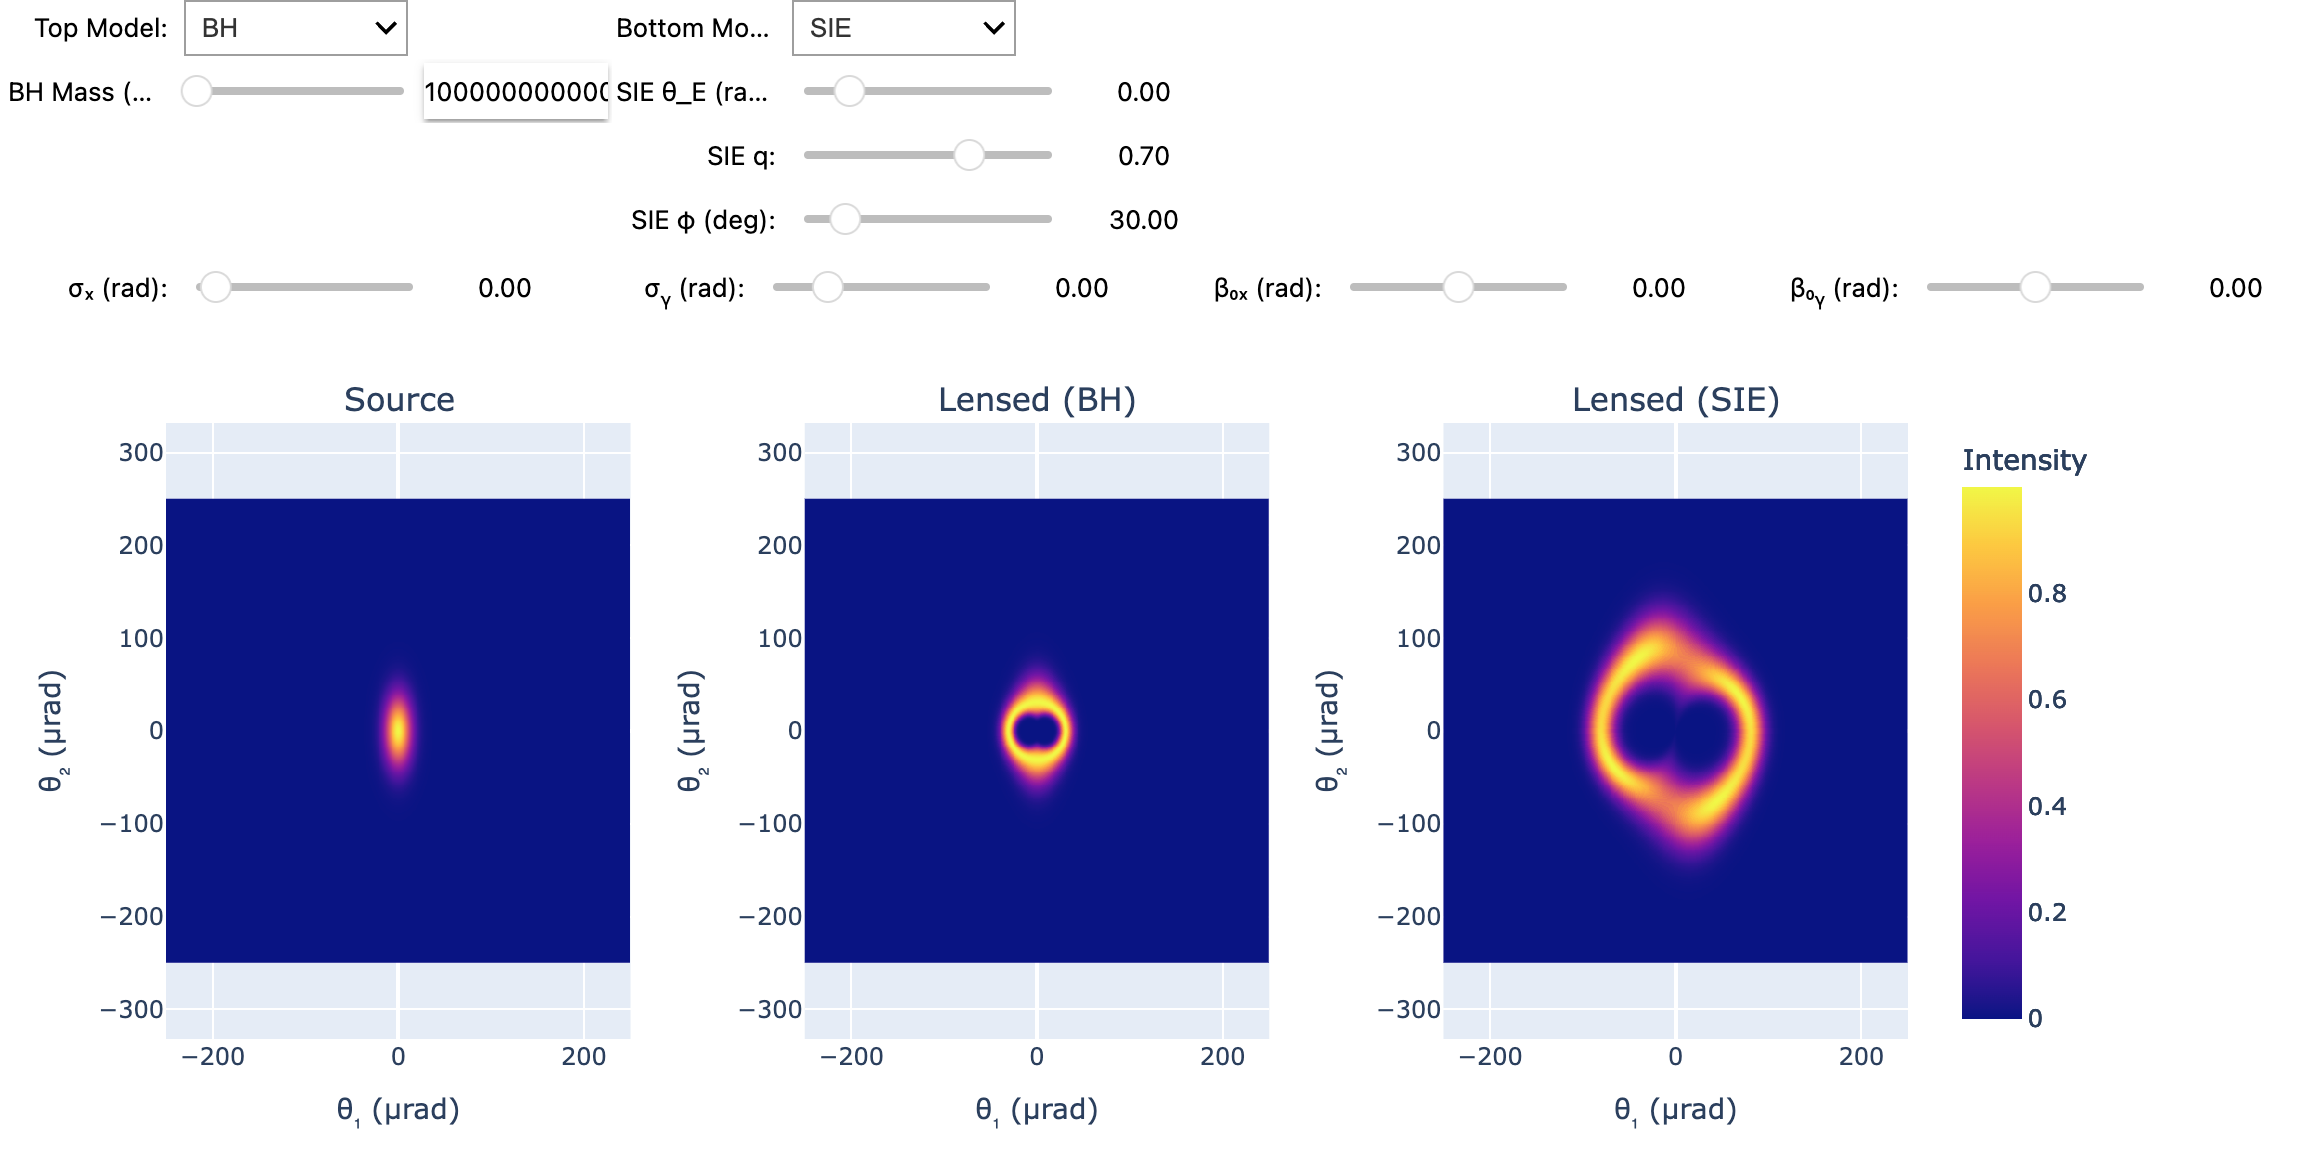

In [10]:
from IPython.display import Image, display
display(Image(filename='lenser.png'))